In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time
import pickle

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.layers import Input
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
num_bins = 45
bin_centers = np.linspace(0, 0.7, num_bins*2+1)[1::2]
vol_bin_centers = bin_centers
sigma_ratio = 0.5
sigma = np.mean(np.diff(bin_centers))*sigma_ratio
preterm = 1 / (2 * np.square(sigma))

def mi_test(y_true, y_pred):
    """ soft mutual info """
    y_pred = np.clip(y_pred, 0, 0.7)
    y_true = np.clip(y_true, 0, 0.7)

    # reshape: flatten images into shape (batch_size, heightxwidthxdepthxchan, 1)
    y_true = np.reshape(y_true, (-1, np.prod(np.shape(y_true)[1:])))
    y_true = np.expand_dims(y_true, 2)
    y_pred = np.reshape(y_pred, (-1, np.prod(np.shape(y_pred)[1:])))
    y_pred = np.expand_dims(y_pred, 2)

    nb_voxels = np.shape(y_pred)[1]

    # reshape bin centers to be (1, 1, B)
    o = [1, 1, np.prod(vol_bin_centers.shape)]
    vbc = np.reshape(vol_bin_centers, o)

    # compute image terms
    I_a = np.exp(- preterm * np.square(y_true  - vbc))
    I_a /= np.sum(I_a, -1, keepdims=True)
    print('I_a max', np.max(I_a))

    I_b = np.exp(- preterm * np.square(y_pred  - vbc))
    I_b /= np.sum(I_b, -1, keepdims=True)
    print('I_b max', np.max(I_b))

    # compute probabilities
    I_a_permute = np.transpose(I_a, (0,2,1))
    pab = np.dot(I_a_permute[0,:,:], I_b[0,:,:])  # should be the right size now, nb_labels x nb_bins
    pab /= nb_voxels

#     print(pab_val[0,:,:])
#     print(np.max(pab_val[0,:,:]))

    pa = np.mean(I_a, axis=1, keepdims=True)
    pb = np.mean(I_b, axis=1, keepdims=True)
    epsilon = 10**(-7)
    papb = np.dot(np.transpose(pa, (0,2,1))[0,:,:], pb[0,:,:]) + epsilon
    mi = np.sum(pab * np.log(pab/papb + epsilon))

#     print('mi', mi)
#     slices([pab[1:,1:]])
    return mi, pab

In [6]:
vol_size = (160, 192, 224)  
def mind(d, patch_size, use_ssc=False, use_gaussian_kernel=False):
    epsilon = 0.000001
    # see http://www.mpheinrich.de/pub/MEDIA_mycopy.pdf
    if use_gaussian_kernel:
        dist = tf.distributions.Normal(0., 1.)

        vals = dist.prob(tf.range(start = -(patch_size-1)/2, limit = (patch_size-1)/2 + 1, dtype = tf.float32))
        kernel = tf.einsum('i,j,k->ijk', vals, vals, vals)
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = kernel[:,:,:,tf.newaxis, tf.newaxis]
    else:
        kernel = tf.ones([patch_size, patch_size, patch_size, 1, 1])/(patch_size**3)
        
    def ssd_shift(image, direction):
        # expects a 3d image
        x,y,z = vol_size
        new_shift = np.clip(direction, 0, None)
        old_shift = -np.clip(direction, None, 0)

        # translate images
        new_image = image[new_shift[0]:x-old_shift[0], new_shift[1]:y-old_shift[1], new_shift[2]:z-old_shift[2]]
        old_image = image[old_shift[0]:x-new_shift[0], old_shift[1]:y-new_shift[1], old_shift[2]:z-new_shift[2]]
        # get squared difference
        diff = tf.square(new_image - old_image)

        # pad the diff
        padding = np.transpose([old_shift, new_shift])
        diff = tf.pad(diff, padding)

        # apply convolution
        conv = tf.nn.conv3d(diff[tf.newaxis,:,:,:,tf.newaxis], kernel, [1]*5, 'SAME')
        return conv

    def mind_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0

        y_true_var = 0
        y_pred_var = 0
        for i in range(ndims):
            direction = [0]*ndims
            direction[i] = d

            y_true_var += ssd_shift(y_true, direction)
            y_pred_var += ssd_shift(y_pred, direction)

            direction = [0]*ndims
            direction[i] = -d
            y_true_var += ssd_shift(y_true, direction)
            y_pred_var += ssd_shift(y_pred, direction)

        y_true_var = y_true_var/(ndims*2) + epsilon
        y_pred_var = y_pred_var/(ndims*2) + epsilon

        for i in range(ndims):
            direction = [0]*ndims
            direction[i] = d

            loss_tensor += tf.reduce_mean(tf.abs(tf.exp(-ssd_shift(y_true, direction)/y_true_var) - tf.exp(-ssd_shift(y_pred, direction)/y_pred_var)))

            direction = [0]*ndims
            direction[i] = -d
            loss_tensor += tf.reduce_mean(tf.abs(tf.exp(-ssd_shift(y_true, direction)/y_true_var) - tf.exp(-ssd_shift(y_pred, direction)/y_pred_var)))

        return loss_tensor/(ndims*2)

    def ssc_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0
        directions = []
        for i in range(ndims):
            direction = [0]*3
            direction[i] = d
            directions.append(direction)

            direction = [0]*3
            direction[i] = -d
            directions.append(direction)

        for i in range(len(directions)):
            for j in range(i, len(directions)):
                d1 = directions[i]
                d2 = directions[j]

                loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, d1) - ssd_shift(y_pred, d2)))

        return loss_tensor/(len(directions)*(len(directions)-1)/2)

    if use_ssc:
        return ssc_loss
    else:
        return mind_loss

In [7]:
def create_graph(model_name, iter_num, step_size, gpu_id, n_test, invert_images=False, loss_function=None, max_clip=0.7):    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas_vol = nib.load('../data/t1_atlas.nii').get_data()[np.newaxis,...,np.newaxis]
    atlas_seg = nib.load('../data/t1_atlas_seg.nii').get_data()
    
    atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)
    
    dices = []
    loss_arr = []
    
    y_true = Input((1, *vol_size, 1) , name='y_true')
    y_pred = Input((1, *vol_size, 1) , name='y_pred')
    output = loss_function(y_true, y_pred)
    loss_K_function = K.function([y_true, y_pred], [output])
    
    for i in range(iter_num//step_size + 1):
        print(i)
        start_time = time.time()

        # load weights of model
        with tf.device(gpu):
            net = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)
            net.load_weights('../models/' + model_name +
                             '/' + str(i*step_size) + '.h5')

        print('model loaded', time.time()-start_time)
        dice_means = []
        loss_means = []

        with tf.device(gpu):
            sess = tf.Session(config=config)
            for step in range(0, n_test):
                X_vol, X_seg = images[step]
                if invert_images:
                    X_vol = max_clip - X_vol

                pred = net.predict([X_vol, atlas_vol])
                warp_seg = nn_trf_model.predict([X_seg, pred[1]])
                mean = np.mean(kdice_fn([warp_seg[0,:,:,:,0], atlas_seg]))
                dice_means.append(mean)
#                 with sess.as_default():
                if loss_function != None:
                    loss_val = loss_K_function([atlas_vol, pred[0]])[0]
                    print(loss_val)
                    loss_means.append(loss_val)

        print('tested patients', time.time()-start_time)
        dices.append(np.mean(dice_means))
        print('dice at step', i*step_size, dices[-1])
        if loss_function != None:
            loss_arr.append(np.mean(loss_means))
    return dices, loss_arr


In [8]:
model_name = 'mi_inverted_bins48_reg3'
num_iters = 25000
step_size = 1000
gpu_id = 2
n_test = 10

d = 2
patch_size = 3
use_ssc = False
use_gaussian_kernel = False

loss_function = mind(d, patch_size, use_ssc=use_ssc, use_gaussian_kernel=use_gaussian_kernel)

dices, loss_arr = create_graph(model_name, num_iters, step_size, gpu_id, n_test, loss_function=loss_function, invert_images=True)

Using GPU:2 with 0% of the memory
Using GPU:2 with 0% of the memory
0
model loaded 1.1200718879699707
0.10876767
0.09900545
0.09803011
0.101758525
0.09229204
0.09855562
0.09520024
0.09322533
0.09846827
0.091768995
tested patients 23.277624130249023
dice at step 0 0.58011544
1
model loaded 1.1148607730865479
0.10367845
0.09480553
0.096130535
0.0996948
0.08666004
0.094878726
0.09241369
0.09032451
0.09575552
0.08985433
tested patients 14.690371990203857
dice at step 1000 0.66885674
2
model loaded 1.1211223602294922
0.10318371
0.09403124
0.095323876
0.09880346
0.08614462
0.09432697
0.091911994
0.08940249
0.0948654
0.08897596
tested patients 14.759386777877808
dice at step 2000 0.690618
3
model loaded 1.3651201725006104
0.10388005
0.09426947
0.09566662
0.09912275
0.0864176
0.094633386
0.09228076
0.08987446
0.095069185
0.08926907
tested patients 14.332118272781372
dice at step 3000 0.696317
4
model loaded 1.1106023788452148
0.10233119
0.093248986
0.094461165
0.09799984
0.085244656
0.09347024

In [12]:
file = open('../models/%s/%s.txt' % (model_name, model_name),'wb') 
pickle.dump([num_iters, step_size, dices], file)
file.close()

mi_inverted_bins48_reg3


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


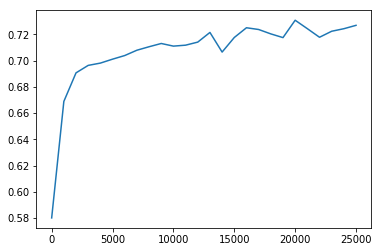

In [56]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
# plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), loss_arr)

# plt.ylim(0.65, 0.67)

mi_inverted_bins48_reg3


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


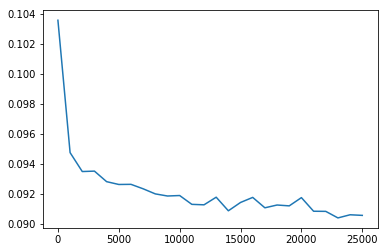

In [54]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), loss_arr)
# plt.ylim(0.65, 0.67)

mi_inverted_bins48_reg3


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


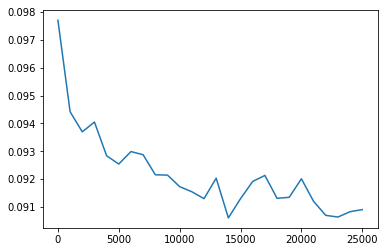

In [9]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), loss_arr)
# plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'MI')

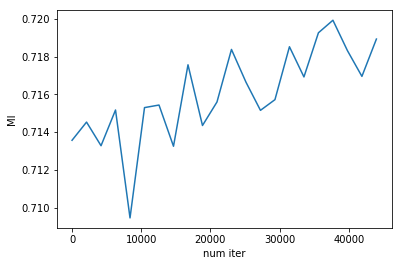

In [9]:
file = open('../models/mi_b45l5/mi_b45l5.txt','rb') 
dices, mis = pickle.load(file)
plt.plot(np.linspace(0, 44000, 44000/2000), mis)
plt.xlabel('num iter')
plt.ylabel('MI')

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


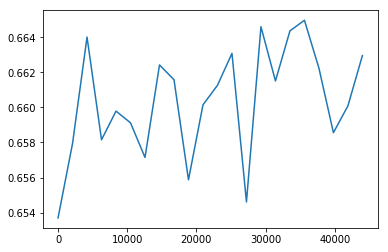

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000), dices)


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


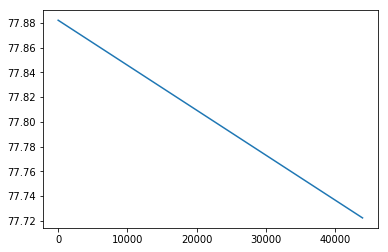

In [9]:
plt.plot(np.linspace(0, 44000, 44000/40000+1), mis)
# plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

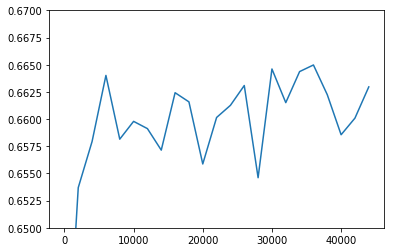

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

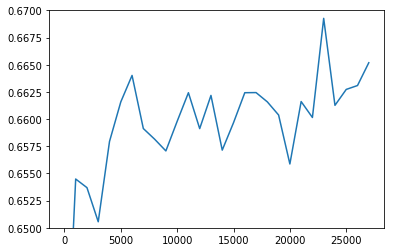

In [20]:
plt.plot(np.linspace(0, 27000, 27000/1000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.72, 0.75)

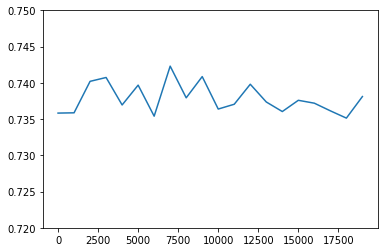

In [7]:
plt.plot(np.linspace(0, 19000, 19000/1000+1), dices)
plt.ylim(0.72, 0.75)

(0.68, 0.72)

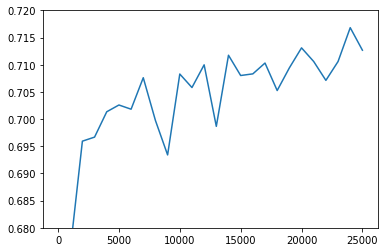

In [20]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.72)

(0.68, 0.7)

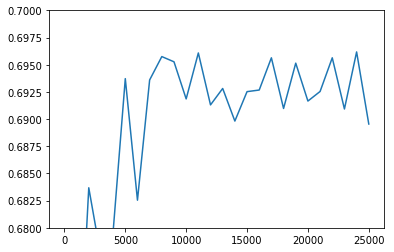

In [19]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.7)

In [21]:
%%time
dices = []
step_size = 5000
for i in range(25000//step_size + 1):
    print(i)
    dices.append(test(model_name, i*step_size, gpu_id, 10, True, 0.7))

0
1
2
3
4
5
CPU times: user 8min 49s, sys: 1min 10s, total: 10min
Wall time: 6min 28s


In [28]:
%%time
dices_2 = []
step_size = 5000
for i in range(iter_num//step_size + 1):
    print(i)
    dices_2.append(test(model_name, i*step_size, gpu_id, 10, False, 0.7))

0
1
2
3
4
5
6
7
8
CPU times: user 13min 28s, sys: 2min 13s, total: 15min 41s
Wall time: 10min 17s


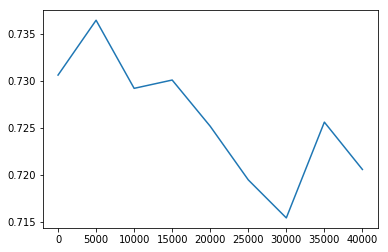

In [30]:
plt.plot([i*step_size for i in range(iter_num//step_size + 1)], dices_2)

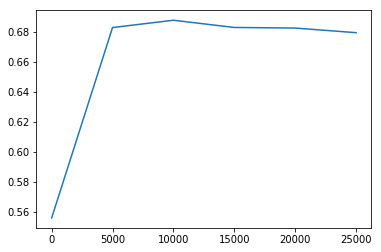

In [31]:
plt.plot([i*step_size for i in range(25000//step_size + 1)], dices)